# Neuro-Symbolic AI
## Sort-of-CLEVR Dataset
### Contents
- Generate Dataset
- Perception Module
    - Train
    - Inference
- Semantic Parser
    - Preprocess Data
    - Train Seq2Seq Model
    - Inference
- Program Executor
- Plugging Everything Together

In [1]:
# Install Pytorch 1.7 and torchtext 0.8
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchtext==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# !git clone https://github.com/nerdimite/neuro-symbolic-ai-soc

In [3]:
# cd neuro-symbolic-ai-soc

In [4]:
from data_generator import *
import numpy as np
import pandas as pd
import os
import dlib
import cv2
from skimage.io import imshow
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as tfms
from PIL import Image

## Dataset Generation

### Breakdown

In [5]:
# Generate a sample i.e.
# a tuple of 1 image, 6 objects' properties, 20 QA vectors (10 relational and 10 non-relational)
sample = build_sample()

In [6]:
# Break down the sample
img, objects, queries, programs, answers = convert_sample(sample)

In [7]:
img = (img * 255).astype('uint8')

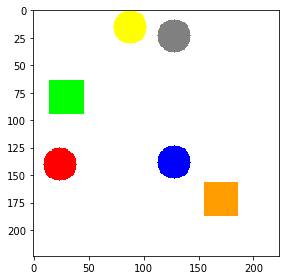

In [8]:
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
objects

[(0, array([ 24, 140]), 'c', (9, 125, 39, 155)),
 (1, array([30, 79]), 'r', (15, 64, 45, 94)),
 (2, array([128, 138]), 'c', (113, 123, 143, 153)),
 (3, array([171, 172]), 'r', (156, 157, 186, 187)),
 (4, array([128,  23]), 'c', (113, 8, 143, 38)),
 (5, array([88, 15]), 'c', (73, 0, 103, 30))]

In [10]:
list(zip(queries, answers, programs))

[('What is the closest shape to the orange object?',
  'circle',
  'filter orange <nxt> relate closest <nxt> query shape'),
 ('What is the furthest shape from the yellow object?',
  'rectangle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the yellow object?',
  'rectangle',
  'filter yellow <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the green object?',
  'rectangle',
  'filter green <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the green object?',
  'rectangle',
  'filter green <nxt> relate furthest <nxt> query shape'),
 ('What is the furthest shape from the gray object?',
  'circle',
  'filter gray <nxt> relate furthest <nxt> query shape'),
 ('How many objects of the same shape as the red object are there?',
  '4',
  'filter red <nxt> query shape <nxt> filter <nxt> count'),
 ('What is the closest shape to the red object?',
  'rectangle',
  'filter red <nxt> relate clos

### Generate the full dataset

In [11]:
# Generate the dataset
n_train_imgs = 100
n_test_imgs = 10

build_dataset(n_train_imgs, data_dir='data/train', prefix='train')
build_dataset(n_test_imgs, data_dir='data/test', prefix='test')

100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]


## Perception Module

### Train the Object Detector

In [12]:
from perception import *

In [13]:
def load_image_data(csv_file, img_dir):
    '''Load the image detection data for training the object detector'''
    # Annotations
    annot = pd.read_csv(csv_file)
    
    data = {}
    for i in range(len(os.listdir(img_dir))):
        # Get all rows belonging to the same scene
        scene = annot[annot['filename'] == f'{i}.jpg']
        # Read the image
        img = cv2.imread(os.path.join(img_dir, f'{i}.jpg'))
        
        # Add bounding box information for dlib
        bboxes = []
        for row in scene.values:
            x1, y1, x2, y2 = row[-4:]
            dlib_box = dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2)
            bboxes.append(dlib_box)
        
        data[i] = (img, bboxes)
    
    return data

In [14]:
# Load the Image Detection Data
det_data = load_image_data('data/train/train_img_det.csv', 'data/train/images')

In [15]:
%%time
# Train the Model
train_detector(det_data, 'detector.svm')

Training Results: precision: 1, recall: 1, average precision: 1
Saved the model to detector.svm
Wall time: 10.5 s


### Shape Classifier

In [16]:
class Binarize():
    '''PyTorch Transforms Object'''
    def __init__(self):
        '''Converts Grayscale to Binary (except white every other color is zeroed)'''
        pass
    
    def __call__(self, img_tensor):
        '''
        Args:
            img_tensor (tensor): 0-1 scaled tensor with 1 channel
        Returns:
            tensor
        '''
        return (img_tensor > 0.95).float()

In [17]:
# Load the images
shapes_data = ImageFolder('data/shapes_data/', transform=tfms.Compose([tfms.Grayscale(), 
                                                                       tfms.Resize((40, 40)), 
                                                                       tfms.ToTensor(),
                                                                       Binarize()]))

In [18]:
shapes_data.class_to_idx

{'circle': 0, 'rectangle': 1}

In [19]:
# Create the dataloader
shapes_loader = DataLoader(shapes_data, batch_size=20, shuffle=True)

In [20]:
# Model
shape_classifier = ShapeClassifier()

In [21]:
# Train
shape_classifier.train_classifier(shapes_loader, lr=0.0001, epochs=50, filename='classifier.pth')

C:\Users\ckkok\Anaconda3\envs\nesy\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1: Mean Loss = 0.780756413936615


Epoch 2:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2: Mean Loss = 0.5656760334968567


Epoch 3:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3: Mean Loss = 0.40746966501077014


Epoch 4:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4: Mean Loss = 0.31802261620759964


Epoch 5:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5: Mean Loss = 0.22192315260569254


Epoch 6:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6: Mean Loss = 0.17538069436947504


Epoch 7:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7: Mean Loss = 0.13320174316565195


Epoch 8:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8: Mean Loss = 0.10135363352795441


Epoch 9:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9: Mean Loss = 0.10432694976528485


Epoch 10:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10: Mean Loss = 0.08294028292099635


Epoch 11:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11: Mean Loss = 0.06972696694235007


Epoch 12:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12: Mean Loss = 0.06631434398392837


Epoch 13:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13: Mean Loss = 0.05170907856275638


Epoch 14:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14: Mean Loss = 0.038860872543106474


Epoch 15:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15: Mean Loss = 0.031098125812908013


Epoch 16:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16: Mean Loss = 0.027517402544617653


Epoch 17:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17: Mean Loss = 0.043344698225458465


Epoch 18:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18: Mean Loss = 0.021973921451717615


Epoch 19:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19: Mean Loss = 0.021143797785043716


Epoch 20:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20: Mean Loss = 0.02480144550402959


Epoch 21:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21: Mean Loss = 0.01991595234721899


Epoch 22:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22: Mean Loss = 0.02517564982796709


Epoch 23:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23: Mean Loss = 0.014945306970427433


Epoch 24:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24: Mean Loss = 0.010685213763887683


Epoch 25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25: Mean Loss = 0.008051348656105498


Epoch 26:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26: Mean Loss = 0.014613055313626925


Epoch 27:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27: Mean Loss = 0.0054656572950383025


Epoch 28:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28: Mean Loss = 0.005996230291202664


Epoch 29:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29: Mean Loss = 0.0038431576977018267


Epoch 30:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30: Mean Loss = 0.009953089116606861


Epoch 31:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31: Mean Loss = 0.00429314326417322


Epoch 32:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32: Mean Loss = 0.0036536562644566097


Epoch 33:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33: Mean Loss = 0.0036688511415074268


Epoch 34:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34: Mean Loss = 0.004415599784503381


Epoch 35:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35: Mean Loss = 0.0049046537023968995


Epoch 36:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36: Mean Loss = 0.0035063092752049365


Epoch 37:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37: Mean Loss = 0.004409417762265851


Epoch 38:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38: Mean Loss = 0.0054602904710918665


Epoch 39:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39: Mean Loss = 0.0037385711329989135


Epoch 40:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40: Mean Loss = 0.002717041982881104


Epoch 41:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41: Mean Loss = 0.0029588647303171456


Epoch 42:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42: Mean Loss = 0.003320045187138021


Epoch 43:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43: Mean Loss = 0.0021286589423349747


Epoch 44:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44: Mean Loss = 0.002258100217053046


Epoch 45:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45: Mean Loss = 0.0017166360363868687


Epoch 46:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46: Mean Loss = 0.001699747294575597


Epoch 47:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47: Mean Loss = 0.001782663680690651


Epoch 48:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48: Mean Loss = 0.0013361232413444668


Epoch 49:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49: Mean Loss = 0.0017869313693760585


Epoch 50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50: Mean Loss = 0.0009037268027896062


### Perception Pipeline
`detector -> attribute (shape and color) extraction -> structural scene representation`

In [22]:
# Load the Model
perceiver = PerceptionPipe('detector.svm', 'classifier.pth')

### Breakdown

In [23]:
# Inference with Detector
objects = perceiver.detect(img)
objects

[(array([[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         ...,
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [  0, 156, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
  
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255

In [24]:
# View the isolated objects (this will not work in colab as its headless)
# for obj, _ in objects:
#     cv2.imshow('frame', obj)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [25]:
# Inference with Attribute Extractor (Shape Classifier, Color Extractor)
shape, color = perceiver.extract_attributes(objects[3][0])
print(f'Shape = {shape}\nColor = {color}')

Shape = circle
Color = blue


### Pipeline

In [26]:
scene = perceiver.scene_repr(img)
scene

,shape,color,position
0,rectangle,orange,"(171, 172)"
1,circle,gray,"(127, 20)"
2,circle,red,"(23, 140)"
3,circle,blue,"(127, 136)"
4,rectangle,green,"(31, 80)"
5,circle,yellow,"(87, 17)"


## Semantic Parser

### Preprocess Data

In [27]:
from semantic_parser import *
from torchtext.legacy.data import BucketIterator

In [28]:
# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [29]:
# Create the preprocessor object and preprocess
preproc = Preprocessor('data/train/train_q2p.csv')

In [30]:
# Get the dataset object
train_data = preproc.train_data

In [31]:
# Looking at the Vocabulary
preproc.prog_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x000001DB7EE27CD0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '<nxt>': 4,
             'filter': 5,
             'query': 6,
             'shape': 7,
             'position': 8,
             'relate': 9,
             'orange': 10,
             'gray': 11,
             'count': 12,
             'isleft': 13,
             'istop': 14,
             'closest': 15,
             'red': 16,
             'yellow': 17,
             'furthest': 18,
             'blue': 19,
             'green': 20})

In [32]:
# Looking at the Vocabulary
preproc.que_f.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x000001DB7EE27B20>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'the': 4,
             '?': 5,
             'object': 6,
             'is': 7,
             'shape': 8,
             'there': 9,
             'what': 10,
             'a': 11,
             'on': 12,
             'of': 13,
             'orange': 14,
             'gray': 15,
             'are': 16,
             'as': 17,
             'how': 18,
             'many': 19,
             'objects': 20,
             'same': 21,
             'left': 22,
             'top': 23,
             'closest': 24,
             'to': 25,
             'red': 26,
             'yellow': 27,
             'from': 28,
             'furthest': 29,
             'blue': 30,
             'green': 31})

### Training

In [33]:
# Training hyperparameters
num_epochs = 3
learning_rate = 3e-4
batch_size = 8
num_steps = len(train_data) / batch_size

# Model hyperparameters
config = {
    'que_vocab_size': len(preproc.que_f.vocab),
    'prog_vocab_size': len(preproc.prog_f.vocab),
    'embedding_dim': 256,
    'num_heads': 8,
    'num_encoder_layers': 3,
    'num_decoder_layers': 3,
    'dropout': 0.10,
    'max_len': 20,
    'forward_expansion': 4,
    'que_pad_idx': preproc.que_f.vocab.stoi["<pad>"]
}

In [34]:
# Save the config as a json file
import json
with open('config.json', 'w') as f:
    json.dump(config, f)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
# Create Training Generator
train_loader = BucketIterator.splits((train_data,),
                                     batch_size=batch_size,
                                     sort_within_batch=True,
                                     sort_key=lambda x: len(x.query),
                                     device=device)[0]

In [37]:
# Create Model
seq2seq = Seq2Seq(config)

In [38]:
%%time
# Train Model
seq2seq.train_model(train_loader, num_epochs, num_steps, filename='semantic_parser.pth')

Epoch 1:   0%|          | 0/250.0 [00:00<?, ?it/s]

Epoch 1: Mean Loss = 0.23741953336354346



Epoch 2:   0%|          | 0/250.0 [00:00<?, ?it/s]

Epoch 2: Mean Loss = 0.001959896667394787



Epoch 3:   0%|          | 0/250.0 [00:00<?, ?it/s]

Epoch 3: Mean Loss = 0.0008725586156360805

Wall time: 1min 5s


### Inference on Queries

In [39]:
sem_parser = SemanticParser(preproc, config, device='cpu')

In [40]:
program = sem_parser.predict('What is the furthest shape from the green object?')
program

['filter green', 'relate furthest', 'query shape']

## Program Executor

In [41]:
from program_executor import ProgramExecutor

In [42]:
executor = ProgramExecutor()

In [43]:
queries

['What is the closest shape to the orange object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the yellow object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the green object?',
 'What is the furthest shape from the gray object?',
 'How many objects of the same shape as the red object are there?',
 'What is the closest shape to the red object?',
 'What is the closest shape to the green object?',
 'How many objects of the same shape as the blue object are there?',
 'What is the shape of the yellow object?',
 'Is there a red object on the top?',
 'Is there a orange object on the left?',
 'What is the shape of the red object?',
 'Is there a yellow object on the left?',
 'Is there a red object on the left?',
 'Is there a green object on the top?',
 'Is there a blue object on the left?',
 'Is there a orange object on the left?',
 'Is there a yellow object on the left?']

In [44]:
# Run the program executor with on a full sample of 20 queries
pred_ans = []
for que in queries:
    program = sem_parser.predict(que)
    pred_ans.append(executor(scene, program))

In [45]:
list(zip(pred_ans, answers))

[('circle', 'circle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('rectangle', 'rectangle'),
 ('circle', 'circle'),
 (4, '4'),
 ('rectangle', 'rectangle'),
 ('circle', 'circle'),
 (4, '4'),
 ('circle', 'circle'),
 ('no', 'no'),
 ('no', 'no'),
 ('circle', 'circle'),
 ('yes', 'yes'),
 ('yes', 'yes'),
 ('yes', 'yes'),
 ('no', 'no'),
 ('no', 'no'),
 ('yes', 'yes')]

## Plugging Everything Together

In [46]:
from program_executor import *
from perception import *
from semantic_parser import *
import torch
from skimage.io import imshow
import cv2

In [47]:
# Load the config file for transformers
import json
with open('config.json', 'r') as f:
    config = json.load(f)

In [48]:
class NSAIPipeline():
    '''End-to-End Pipeline of Neuro-Symbolic AI on Sort-of-CLEVR dataset'''
    def __init__(self, 
                 config,
                 detector='models/detector.svm',
                 classifier='models/classifier.pth',
                 sem_parser='models/semantic_parser.pth',
                 train_csv='data/train/train_q2p.csv',
                 device=None):
        
        if device is None:
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        
        # Perception Module
        self.perceiver = PerceptionPipe(detector, classifier, self.device)
        
        # Semantic Parser
        self.preproc = Preprocessor(train_csv)
        self.sem_parser = SemanticParser(self.preproc, config, filename=sem_parser, device=self.device)
        
        # Program Executor
        self.executor = ProgramExecutor()
        
    def predict(self, img, query):
        '''
        Make Prediction on a single image and question pair
        
        Args:
            img (str/array): pixel values should be in 0-255 range
                             of dtype uint8 in BGR color format or
                             file path of the image
            query (str): question about the image
            
        Returns:
            str: answer of the query
        '''
        # Load img if it's a path
        if type(img) == str:
            img = cv2.imread(img)
        
        # Structured Scene Representation
        scene = self.perceiver.scene_repr(img)
        # Synthesize Program from Query
        program = self.sem_parser.predict(query)
        # Execute Program
        answer = self.executor(scene, program)
        
        return answer, program
    
    def evaluate(self, csv, img_dir, debug=True):
        '''
        Evaluate the model on a dataset
        
        Args:
            csv (str): path of the csv containing image filename, answer, query and program
            img_dir (str): directory containing the images
            debug (bool): View the data points which were wrong
        Returns:
            int: accuracy of the model
        '''
        data = pd.read_csv(csv).values
        
        correct = []
        for filename, answer, query, program in tqdm(data):
            # Load Image
            img_path = os.path.join(img_dir, filename)
            img = cv2.imread(img_path)
            
            # Make prediction
            pred, pred_prog = self.predict(img, query)
            
            # Verify answer
            if str(pred) == answer:
                correct.append(1)
            else:
                if debug:
                    print(filename, answer, pred, query, pred_prog)
                correct.append(0)
        
        acc = (sum(correct) / len(correct)) * 100
        
        return acc

In [49]:
nsai = NSAIPipeline(config)

In [50]:
nsai.predict('data/test/images/1.jpg', 'How many objects of the same shape as the gray object are there?')

(6, ['filter gray', 'query shape', 'filter', 'count'])

In [51]:
# Evaluate on the test and get the accuracy
nsai.evaluate('data/test/test_q2p.csv', 'data/test/images/', debug=False)

  0%|          | 0/200 [00:00<?, ?it/s]

99.0

---
#### Debugging

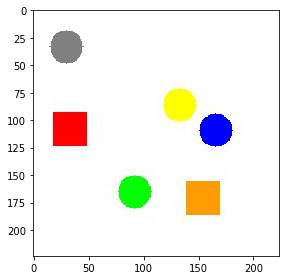

In [52]:
img2 = cv2.imread('data/train/images/2.jpg')
imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [53]:
nsai.executor.scene = nsai.perceiver.scene_repr(img2)
nsai.executor.scene

,shape,color,position
0,rectangle,orange,"(155, 172)"
1,rectangle,red,"(31, 108)"
2,circle,green,"(91, 164)"
3,circle,blue,"(167, 108)"
4,circle,gray,"(31, 32)"
5,circle,yellow,"(131, 84)"


In [56]:
program = nsai.sem_parser.predict('How many objects of the same shape as the red object are there? ')
program

['filter red', 'query shape', 'filter', 'count']

In [57]:
nsai.executor.count(nsai.executor.filter_(nsai.executor.query(nsai.executor.filter_('red'), 'shape')))

2